# Benchmark Analysis
Benchmark data is found under /swann/benchmark

In [1]:
# Imports
import csv
import pandas as pd
import glob

In [26]:
# Helper functions

def csv_to_df(file: str):
    """ Takes in a benchmark file and returns as Pandas DataFrame """
    df = pd.read_csv(
        f'/swann/benchmark/{file}',
        header = 9
    )
    df.dropna(axis=1, inplace=True)
    return df

def get_benchmarks():
    """ Find all csv files in benchmark folder sorted by date """
    files = glob.glob('/swann/benchmark/*.csv')
    files.sort()
    return files

def filter_df_with_wildcard_name(df: pd.DataFrame, name: str):
    """
        Example:
            - name = "LoadDatasets"
        Will return rows where name is "*LoadDatasets*"
    """
    return df.loc[df['name'].str.contains(name)]

def add_empty_time(df: pd.DataFrame, name: str):
    return pd.concat([
        pd.DataFrame(data={
            "name": [f"{name}/-1"],
            "iterations": [1],
            "real_time": [0],
            "cpu_time": [0],
            "time_unit": ["ms"],
            "input_size": [0]
        }),
        df
    ], ignore_index=True)

In [3]:
for bm in get_benchmarks():
    print(f'[+] {bm}')

[+] /swann/benchmark/benchmark-1677845278.csv
[+] /swann/benchmark/benchmark-1678891718.csv
[+] /swann/benchmark/benchmark-1678967932.csv
[+] /swann/benchmark/benchmark-1678993398.csv


### How to load a dataset

In [4]:
# Load benchmark that has loading / parsing of datasets of size XS and S
df_bm_loadparse = csv_to_df('benchmark-1677845278.csv')
df_bm_loadparse

,name,iterations,real_time,cpu_time,time_unit,input_size
0,LoadDatasets/100000,1,2602.41,2532.48,ms,100000
1,LoadDatasets/300000,1,7749.27,7604.63,ms,300000
2,ParseDatasets/100000,1,2538.79,2520.52,ms,100000
3,ParseDatasets/300000,1,7710.79,7691.85,ms,300000


# Visualize data

### Benchmark Query

In [63]:
df_bm_query = csv_to_df("benchmark-1678993398.csv")

df_query = filter_df_with_wildcard_name(df_bm_query, "Query10PointsLSHForest")
df_query = add_empty_time(df_query, "Query10PointsLSHForest")

# Set input size
df_query.at[0, 'input_size'] = 0
df_query.at[1, 'input_size'] = 90_000
df_query.at[2, 'input_size'] = 290_000

# Show in seconds
df_query.at[0, 'cpu_time'] /= 10_000
df_query.at[1, 'cpu_time'] /= 10_000
df_query.at[2, 'cpu_time'] /= 10_000
df_query

,name,iterations,real_time,cpu_time,time_unit,input_size,recall
0,Query10PointsLSHForest/-1,1,0.0,0.00000,ms,0.0,NaN
1,Query10PointsLSHForest/0,1,15214.0,1.52140,ms,90000.0,0.36978
2,Query10PointsLSHForest/1,1,26299.6,2.62994,ms,290000.0,0.35040


Text(0, 0.5, 'Time (ms)')

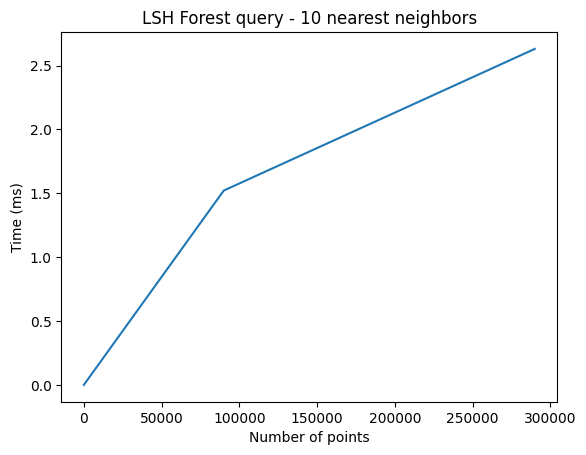

In [64]:
df_query_line = df_query.plot.line(title='LSH Forest query - 10 nearest neighbors', x='input_size', y='cpu_time', legend=False)
df_query_line.set_xlabel("Number of points")
df_query_line.set_ylabel("Time (ms)")

### Loading of dataset

In [5]:
df_load = filter_df_with_wildcard_name(df_bm_loadparse, "LoadDatasets")
df_load_0 = pd.DataFrame(data={
    "name": ["LoadDatasets/000000"],
    "iterations": [1],
    "real_time": [0],
    "cpu_time": [0],
    "time_unit": ["ms"],
    "input_size": [0]
})
df_load = pd.concat([df_load_0, df_load])
df_load

,name,iterations,real_time,cpu_time,time_unit,input_size
0,LoadDatasets/000000,1,0.00,0.00,ms,0
0,LoadDatasets/100000,1,2602.41,2532.48,ms,100000
1,LoadDatasets/300000,1,7749.27,7604.63,ms,300000


Text(0, 0.5, 'Time (ms)')

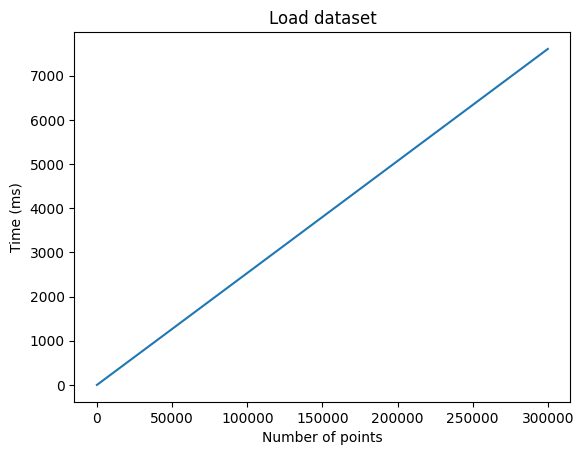

In [6]:
load_line = df_load.plot.line(title='Load dataset', x='input_size', y='cpu_time', legend=False)
load_line.set_xlabel("Number of points")
load_line.set_ylabel("Time (ms)")